<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/advection1D_FipyFiniteVolume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy
# uncomment to install fipy then restart the runtime environment

In [2]:
import numpy as np
from fipy import *

In [3]:
# space discretization
xL = 0.
xR = 1.
dx = 0.01
delX = xR - xL
nx = int(delX/dx)
mesh = Grid1D(nx=nx, dx=dx) + xL

In [4]:
# time discretization
Cr = 0.5 # Courant Number: Cr = u*dt/dx
u = 1.
dt = Cr*dx/u
delT = 0.7
stepsNbr = int(delT/dt)

In [5]:
# defining the unkown's distribution
def distributionIn1D(x, yMin, yMax, xc, width, isRectangular = True):
  if isRectangular:
    # rectangular distribuition
    return np.array([yMax if xc-width < xi and xi < xc+width else yMin for xi in x])
  else:
    # Gaussian distribuition
    return yMin + yMax * np.exp(-(x - xc) ** 2 / (2 * width ** 2))

In [6]:
# initialization
yMin = 0.
yMax = 1.
xc = 0.25
width = 0.05

def initialize():
    # unkown's initialization
    global mesh, yMin, yMax, xc, width, yInit, y
    yInitValue = distributionIn1D(x=mesh.x,
                                  yMin=yMin,
                                  yMax=yMax,
                                  xc=xc,
                                  width=width,
                                  isRectangular=False)
    yInit = CellVariable(mesh=mesh, value=yInitValue)
    y = CellVariable(mesh=mesh, value=yInit)

    # defining the BCs and the discritized eq.
    # 1. Dirichlet BC upstream, 
    # obs. for comparaison with FD, we are limited here for, u > 0, hence
    # upstream boundary corresponds to facesLeft, (not right)
    y.faceValue.constrain(yMin, where=mesh.facesLeft)
    # 2. Absorbing BC downstream
    # obs. this is already implemented in the equation as fixed flux BC

    # Defining the discritized equation
    global u, eq
    convCoeff = (u,)
    eq = TransientTerm(coeff=1.0, var=y) \
       + VanLeerConvectionTerm(coeff=convCoeff, var=y) \
       == -((convCoeff * y.faceValue) * mesh.facesRight).divergence
    # obs. check also, VanLeerConvectionTerm()

In [7]:
# defining the time-step update function for the
def advect1(y, dt):
    eq.solve(var=y, dt=dt)

In [8]:
# displaying some parameters
print('Cr = ', Cr, '\n'
      'dx = ', dx, '\n'
      'u = ', u, '\n'
      'dt = ', dt, '\n'
      'delT = ', delT, '\n'
      'stepsNbr = ', stepsNbr)

Cr =  0.5 
dx =  0.01 
u =  1.0 
dt =  0.005 
delT =  0.7 
stepsNbr =  140


In [9]:
# initialize and iterate in time
initialize()
for step in range(stepsNbr):
  advect1(y, dt)

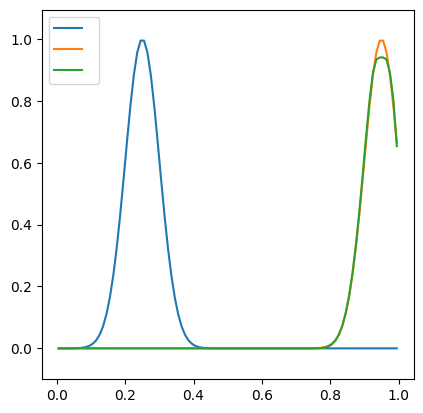

In [10]:
# Ploting the results
yImag = CellVariable(mesh=mesh,
                     value=distributionIn1D(x=mesh.x,
                                            yMin=yMin,
                                            yMax=yMax,
                                            xc=xc+u*stepsNbr*dt,
                                            width=width,
                                            isRectangular = False))
viewer = Viewer(vars = (yInit, yImag, y),
                datamin = min(yInit.min(), y.min())-.1,
                datamax = max(yInit.max(), y.max())+.1)
viewer.plot()